In [40]:
import random
import statistics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Ucelove funkce

In [41]:
def one_max(x: list) -> int:
    """
    One Max ucelova funkce

    Parametry:
        x - Pole bitu 0/1

    Return: Pocet bitu s hodnotou 1
    """
    return sum(x)


def leading_ones(x: list) -> int:
    """
    Leading ones ucelova funkce

    Parametry:
        x - Pole bitu 0/1

    Return: Pocet bit "1" z leve strany binarniho retezcee
    """
    count = 0
    for bit in x:
        if bit == 1:
            count += 1
        else:
            break
    return count

# Definice tridy jedince populace

In [42]:
class BinIndividual:
    def __init__(self, chromosome: list, fitness_function):
        """
        Vytvori jedince populace

        Parametry:
            chromosome - chromozom jedince (v tomto pripade binarni retezec)  
            fitness_function - reference na ucelovou funkci pro hodnoceni kvality jedince
        """
        self.chromosome = chromosome
        self.fitness_function = fitness_function
        self.fitness = 0

    def get_chromosome(self):
        """
        Navrati chromozom jedince
        """
        return self.chromosome
    
    def get_fitness(self):
        """
        Navrati hodnotu kvality uzivatele
        """
        return self.fitness

    def evaluate_fitness(self):
        """
        Ohodnoti kvalitu jedince
        """
        self.fitness = self.fitness_function(self.chromosome)

    def mutate(self, probability: float):
        """
        Mutace, zmutuju chromozom jedince

        Paramtery:
            x - Pole bitu 0/1
            probability - Pravdepodobnost mutace jednoho bitu retezce
        """
        mutated = []
        for bit in self.chromosome:
            if random.random() < probability:
                mutated.append(1 - bit)
            else:
                mutated.append(bit)
        self.chromosome = mutated

    def crossover(self, other):
        """
        Jednobodove krizeni

        Paramtery:
            other - Reference na druheho rodice "jedince populace"

        Return: Potomek 1, Potomek 2
        """
        point = random.randint(1, len(self.chromosome) - 1)
        child1 = self.chromosome[:point] + other.get_chromosome()[point:]
        child2 = other.get_chromosome()[:point] + self.chromosome[point:]
        return BinIndividual(child1, self.fitness_function), BinIndividual(child2, self.fitness_function)

# Definice tridy populace

In [50]:
class BinPopulation:

    def __init__(self, individuals: list[BinIndividual]) -> None:
        """
        Vytvori populaci jedincu
        
        Paramtery:
            individuals - inicializacni list s jedinci populace
        """
        self.individuals = individuals
        pass

    def random_init(self, population_size: int, chromosome_lengths: int, fitness_function):
        """
        Nahodna inicializace populace

        Parametry:
            population_size - Velikost populace
            chromosome_lengths - Delka chromozomu jedince  
            fitness_function - Reference na ucelovou funkci hodnotici kvalitu jedincu v populaci
        """
        self.individuals.clear()

        for _ in range(population_size):
            chromosome = [random.randint(0, 1) for _ in range(chromosome_lengths)]
            individual = BinIndividual(chromosome, fitness_function)
            self.individuals.append(individual)

    def add_individual(self, individual: BinIndividual):
        """
        Prida jedince do populace

        Paramtery:
            individual - Jedinec populace

        Return: 
        """
        self.individuals.append(individual)

    def select_roulette(self) -> BinIndividual:
        """
        Rulotova selekce

        Return: Vybrany potomek populace
        """
        total_fitness = sum(i.fitness for i in self.individuals)
        r = random.uniform(0, total_fitness)
        current_fitness = 0
        for i in self.individuals:
            current_fitness += i.get_fitness()
            if current_fitness >= r:
                return i

    def select_rank(self) -> BinIndividual:
        """
        Poradova selekce

        Return: Vybrany potomek populace
        """
        ranks = list(range(1, len(self.individuals) + 1))
        total_rank = sum(ranks)
        probabilities = [rank / total_rank for rank in ranks]
        selected_index = random.choices(
            range(len(self.individuals)), probabilities)[0]
        return self.individuals[selected_index]
    
    def evaluate_population(self):
        """
        Ohodnoti celou populaci jedincu
        """
        for i in self.individuals:
            i.evaluate_fitness()

    def calculate_stats(self) -> tuple([float, float, float, float, float]):
        """
        Vypocet statistickych udaju populace

        Return: min. hodnota fitness, max. hodnota fitness, prumer, median, smerodatna odchyka
        """
        self.evaluate_population()
        fitness_values = [i.get_fitness() for i in self.individuals]
        if not fitness_values:
            return None, None, None, None 

        min_fitness = min(fitness_values)
        max_fitness = max(fitness_values)
        mean_fitness = statistics.mean(fitness_values)
        median_fitness = statistics.median(fitness_values)
        std_deviation_fitness = statistics.stdev(fitness_values)

        return min_fitness, max_fitness, mean_fitness, median_fitness, std_deviation_fitness

# Trida implementujici chromosometicky algoritmus

In [44]:
class GeneticAlgorithm:
    def __init__(self, population: BinPopulation, elitism_ratio: float, selection_type: str, mutation_probability: float, num_generations: int):
        self.population = population
        self.elitism_ratio = elitism_ratio
        self.selection_type = selection_type
        self.mutation_probability = mutation_probability
        self.num_generations = num_generations

    def __select_individual(self):
        """
        Vyber jedince podle zvoleneho typu vyberu (roulette nebo rank)

        Return: Vybrany jedinec
        """
        if self.selection_type == 'roulette':
            return self.population.select_roulette()
        elif self.selection_type == 'rank':
            return self.population.select_rank()
        else:
            raise ValueError("Undefined selector type")

    def __evolve_population(self):
        """
        Vytvori novou generaci potomku a ta nahradi tu aktualni
        """
        new_population = list()

        elite_count = int(self.elitism_ratio *
                          len(self.population.individuals))
        elites = sorted(self.population.individuals,
                        key=lambda x: -x.get_fitness())[:elite_count]
        new_population.extend(elites)

        while len(new_population) < len(self.population.individuals):
            parent1 = self.__select_individual()
            parent2 = self.__select_individual()
            child1, child2 = parent1.crossover(parent2)
            child1.mutate(self.mutation_probability)
            child2.mutate(self.mutation_probability)
            new_population.extend([child1, child2])

        self.population.individuals = new_population

    def run(self) -> list[float]:
        """
        Spusti geneticky algoritmus

        Return: Prubeh hodnoty ucelove funkce nejlepsiho jedince v ramci vsech chromosomeraci
        """
        fitness_history = []
        for _ in range(self.num_generations):
            self.population.evaluate_population()
            # nejlepsi hodna fitness v populaci (ohodnoceni nejlepsiho jedince)
            best_fitness = max(individual.get_fitness()
                               for individual in self.population.individuals)
            fitness_history.append(best_fitness)
            # vyvinuti populace
            self.__evolve_population()
        
        return fitness_history

# Utils

In [45]:
def plot_convergence_graph(axs, fitness_history: list, graph_title: str, label: str):
    """
    Vykresli konvergencni graf
    """
    chromosomerations = list(range(len(fitness_history)))
    axs.plot(chromosomerations, fitness_history, label=label)
    axs.set_title(f'Convergence graph for {graph_title}')
    axs.set_xlabel('Generation')
    axs.set_ylabel('Fitness')
    axs.legend()
    axs.grid(True)

In [46]:
def print_results(axs, fitness_histories: list[list], stats_list: list[list], num_runs: int, dim: int, label: str):
    """
    Vypise stisticky zpracovany vysledek
    """
    average_fitness_history = [sum(e[i] for e in fitness_histories) / num_runs for i in range(len(fitness_histories[0]))]
    average_stats = [sum(stats[i] for stats in stats_list) / num_runs for i in range(len(stats_list[0]))]
    plot_convergence_graph(axs, average_fitness_history, "%d D" % (dim), label)
    print("%s %dD = Min: %f, Max: %f, Mean: %f, Median: %f, Std Dev: %f" % (label, dim, average_stats[0], average_stats[1], average_stats[2], average_stats[3], average_stats[4]))

## Konfigurace

In [56]:
# velikost populace
population_size = 100

# vyberu rodicu
selection_type = 'roulette'

# pravdepodobnost mutace
mutation_probability = 0.01

# delky chromozomu jedince v populaci (v tomto pripade delka binarniho retezce)
chromosome_lengths = [10, 30, 100]

# pocet opakovani pro statisticke zpracovani
num_runs = 10

# Vytvoreni populace

In [57]:
# vytvoreni instace populace, se kterou budeme v prubehu pracovat
pop = BinPopulation([])
print("Population size: %d" % len(pop.individuals))

Population size: 0


In [58]:
def run_test(num_generations):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    ga = GeneticAlgorithm(pop, 0.1, selection_type, mutation_probability, num_generations)

    for func in [leading_ones, one_max]:
        # spusteni genetickeho algoritmu (definovany pocet iteraci v nastaveni => pro statisticke zpracovani)
        for i, dim in enumerate(chromosome_lengths):
            fitness_histories, stats_list = [], []
            for _ in range(num_runs):
                # nahodna inicializace/reinicializace populace
                pop.random_init(population_size, dim, func)
                # spusteni genetickeho algoritmu
                fitness_histories.append(ga.run())
                # vypocet statistickych udaju finalni epochy populace 
                stats_list.append(pop.calculate_stats())

            # vypocet a zobrazeni zprumerovanych vysledku (konvergencni graf + statistika finalni epochy populace)
            func_name = "Leading-Ones" if func == leading_ones else "One-Max"
            print_results(axs[i], fitness_histories, stats_list, num_runs, dim, func_name)

    plt.tight_layout()
    plt.show()

# Leading-Ones & One-Max pro 1000 generaci

Z grafu je mozne videt, ze problem Leading-Ones je slozitejsi a tak trva vice generaci genetickemu algoritmu nez dosahne pozadovaneho reseni.

Leading-Ones 10D = Min: 0.300000, Max: 10.000000, Mean: 9.239000, Median: 10.000000, Std Dev: 2.071556
Leading-Ones 30D = Min: 0.500000, Max: 30.000000, Mean: 23.689000, Median: 29.450000, Std Dev: 9.010615
Leading-Ones 100D = Min: 1.000000, Max: 100.000000, Mean: 56.129000, Median: 54.750000, Std Dev: 34.520622
One-Max 10D = Min: 7.600000, Max: 10.000000, Mean: 9.573000, Median: 10.000000, Std Dev: 0.635986
One-Max 30D = Min: 23.500000, Max: 30.000000, Mean: 28.328000, Median: 28.600000, Std Dev: 1.484228
One-Max 100D = Min: 82.200000, Max: 100.000000, Mean: 93.454000, Median: 93.400000, Std Dev: 4.229244


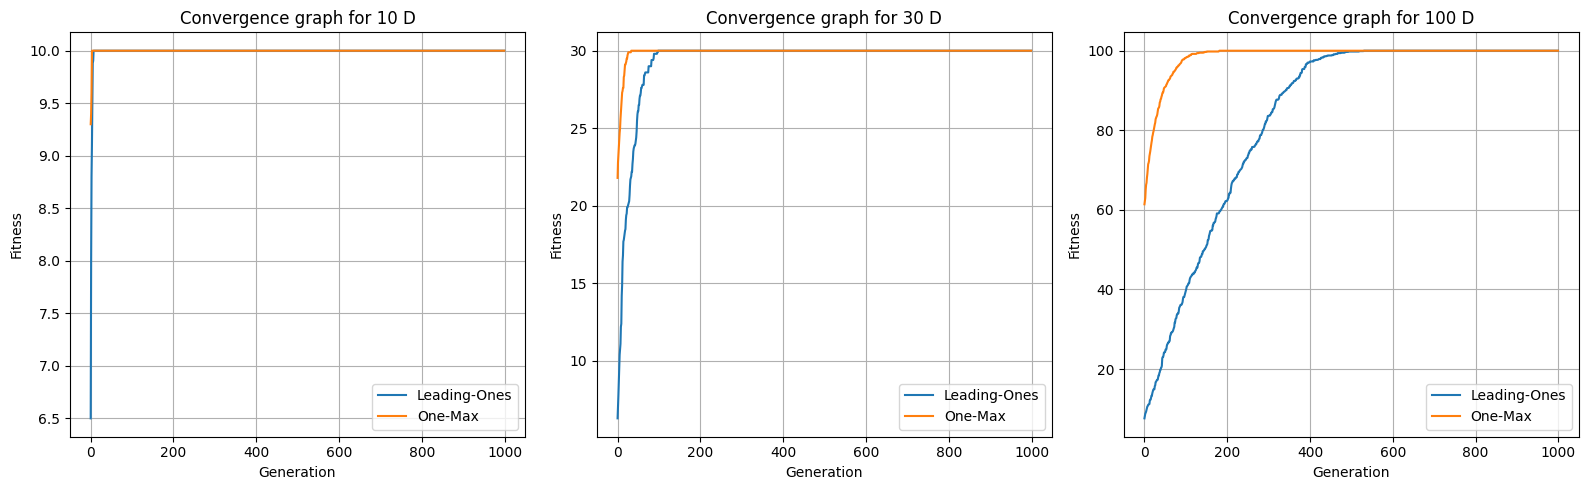

In [59]:
run_test(1000)

# Rank selection (porovnani)

Z výsledku je mozne videt, ze roulette dosahuje lepsich vysledku nez rank. U rank selekce trava populaci mnohem dele nez dosahne optimalniho reseni. Pri problemu 100 D nestacilo 1000 generaci ani pro jeden z resenych problemu.

Leading-Ones 10D = Min: 0.000000, Max: 10.000000, Mean: 2.897000, Median: 1.300000, Std Dev: 3.453511
Leading-Ones 30D = Min: 0.000000, Max: 30.000000, Mean: 5.394000, Median: 2.100000, Std Dev: 8.950848
Leading-Ones 100D = Min: 0.100000, Max: 45.300000, Mean: 7.530000, Median: 2.300000, Std Dev: 13.477803
One-Max 10D = Min: 3.700000, Max: 10.000000, Mean: 7.487000, Median: 7.350000, Std Dev: 1.611921
One-Max 30D = Min: 14.300000, Max: 30.000000, Mean: 21.140000, Median: 20.350000, Std Dev: 3.921201
One-Max 100D = Min: 50.000000, Max: 88.200000, Mean: 65.446000, Median: 63.200000, Std Dev: 9.215118


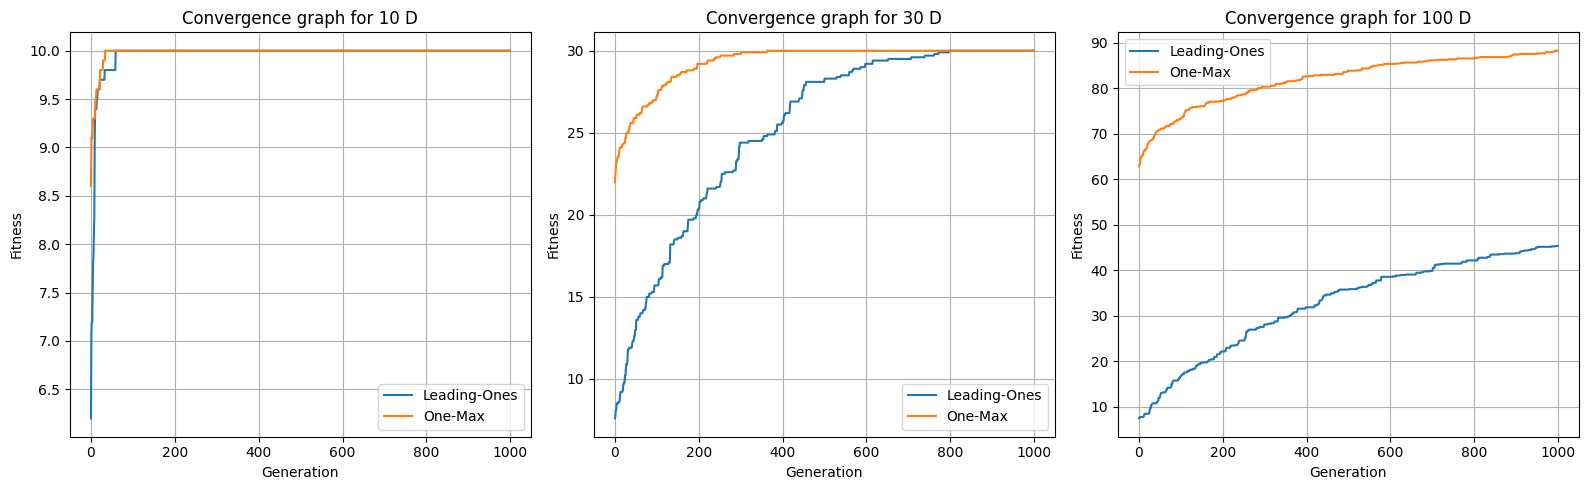

In [61]:
selection_type = 'rank'
run_test(1000)
selection_type = 'roulette'

# Leading-Ones & One-Max pro 3000 generaci

Z grafu neni mozne vycist nejake rozdili oproti '1000' generacim, ale ze statistickych vysledku je mozne pozorovat nejake rozdily. Jde o snizeni smerodatne odchylky, zlepseni hodnot minima, prumeru a medianu. Ty vsak nejsou nijak vyrazne.

Leading-Ones 10D = Min: 0.800000, Max: 10.000000, Mean: 9.232000, Median: 10.000000, Std Dev: 2.025438
Leading-Ones 30D = Min: 0.400000, Max: 30.000000, Mean: 24.289000, Median: 29.900000, Std Dev: 8.345561
Leading-Ones 100D = Min: 0.500000, Max: 100.000000, Mean: 55.496000, Median: 53.700000, Std Dev: 33.497271
One-Max 10D = Min: 7.300000, Max: 10.000000, Mean: 9.587000, Median: 10.000000, Std Dev: 0.640966
One-Max 30D = Min: 23.700000, Max: 30.000000, Mean: 28.328000, Median: 28.500000, Std Dev: 1.467152
One-Max 100D = Min: 84.400000, Max: 100.000000, Mean: 94.087000, Median: 94.300000, Std Dev: 3.980542


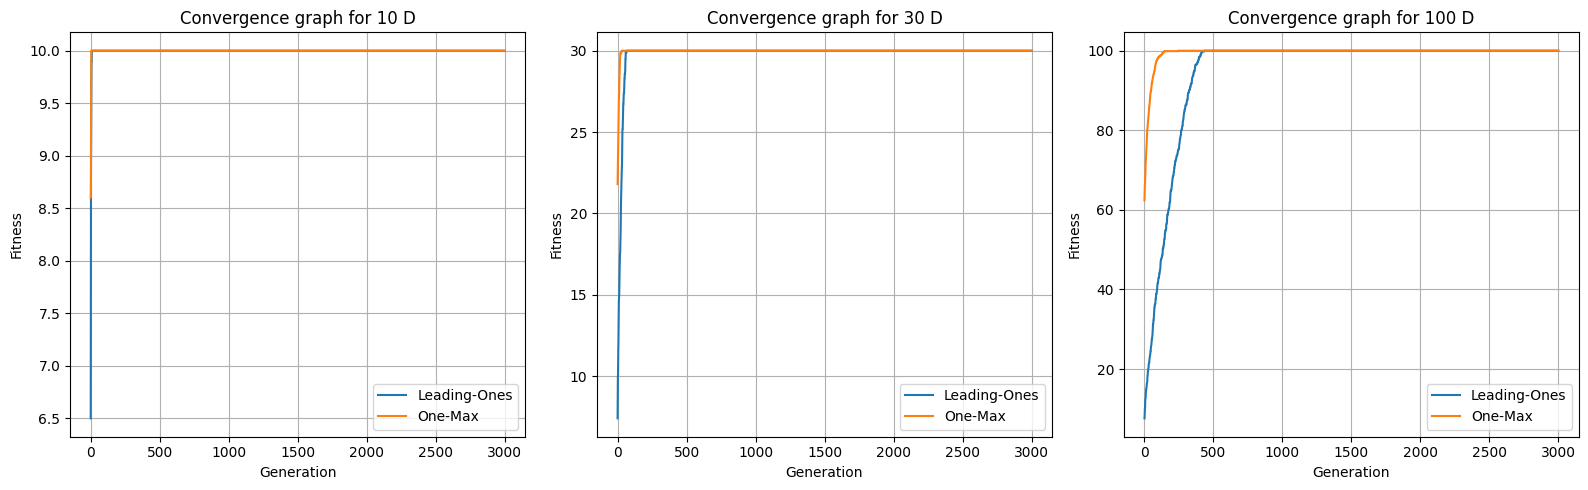

In [60]:
run_test(3000)

# Leading-Ones & One-Max pro 10 000 generaci

Zde jiz nedoslo k zadnemu zlepseni, nejake hodnoty jsou mirne lepsi nebo horsi. Dle techto vysledku je mozne tvrdit, ze doslo k 'saturaci' a tak jiz v ramci populace s timto algoritmem neni mozne dosahnout lepsich hodnot. 

Leading-Ones 10D = Min: 0.800000, Max: 10.000000, Mean: 9.201000, Median: 10.000000, Std Dev: 2.014058
Leading-Ones 30D = Min: 0.300000, Max: 30.000000, Mean: 23.819000, Median: 29.600000, Std Dev: 8.790423
Leading-Ones 100D = Min: 1.100000, Max: 100.000000, Mean: 55.685000, Median: 53.650000, Std Dev: 32.738955
One-Max 10D = Min: 7.400000, Max: 10.000000, Mean: 9.548000, Median: 10.000000, Std Dev: 0.673527
One-Max 30D = Min: 23.500000, Max: 30.000000, Mean: 28.187000, Median: 28.350000, Std Dev: 1.580130
One-Max 100D = Min: 83.200000, Max: 100.000000, Mean: 94.101000, Median: 94.200000, Std Dev: 3.984460


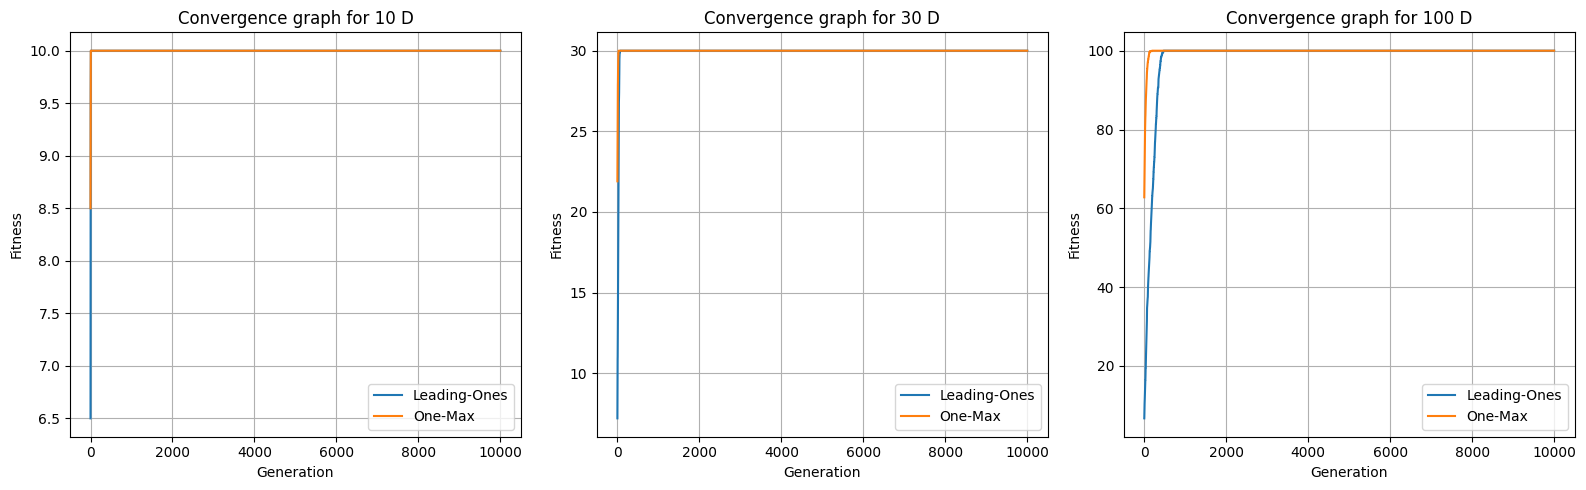

In [62]:
run_test(10000)